## Özellik Mühendisliği ve Özellik Seçimi
1. **Özellik Çıkarımı:**
    - **CUSTOMERS** tablosundan:
        - Müşteri segmenti (büyük, orta, küçük)
    - **ORDERS** tablosundan:
        - Sipariş tarihi ve frekansı gibi zaman serisi özellikleri
        - Ortalama satış tutarı
    - **ORDER_ITEMS** tablosundan:
        - Toplam satış miktarı
        - Ürün kategorisi dağılımı

2. **Özellik Seçimi:**
    - Korelasyon analizi ile yüksek korelasyonlu özelliklerin belirlenmesi
    - Recursive Feature Elimination (RFE) veya Lasso kullanarak en önemli özelliklerin seçilmesi

In [26]:
import pandas as pd 
import numpy as np

customers = pd.read_csv("../Database/customers.csv", sep=',', encoding="Latin-1")
products = pd.read_csv("../Database/products.csv", sep=',', encoding="Latin-1")
orders = pd.read_csv("../Database/orders.csv", sep=',', encoding="Latin-1")
order_items = pd.read_csv("../Database/order_items.csv", sep=',', encoding="Latin-1")

In [42]:
display(orders.head(3)), display(order_items.head(3)), display(customers.head(3)), display(products.head(3))

,ORDERNUMBER,ORDERDATE,STATUS,QTR_ID,DEALSIZE,customer_id
0,10107,2003-02-24,Shipped,1,Small,1
1,10121,2003-05-07,Shipped,2,Small,2
2,10134,2003-07-01,Shipped,3,Medium,3


,ORDERNUMBER,PRODUCTCODE,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES
0,10107,S10_1678,30,95.70,2,2871.00
1,10121,S10_1678,34,81.35,5,2765.90
2,10134,S10_1678,41,94.74,2,3884.34


,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,id
0,Land of Toys Inc.,2125557818,897 Long Airport Avenue,Bilinmiyor,NYC,NY,10022,USA,Bilinmiyor,Yu,Kwai,1
1,Reims Collectables,26471555,59 rue de l'Abbaye,Bilinmiyor,Reims,Bilinmiyor,51100,France,EMEA,Henriot,Paul,2
2,Lyon Souveniers,33146627555,27 rue du Colonel Pierre Avia,Bilinmiyor,Paris,Bilinmiyor,75508,France,EMEA,Da Cunha,Daniel,3


,PRODUCTCODE,PRODUCTLINE,MSRP
0,S10_1678,Motorcycles,95
1,S10_1949,Classic Cars,214
2,S10_2016,Motorcycles,118


(None, None, None, None)

### Customers

In [7]:
c_order_count = orders.groupby('customer_id').size().reset_index(name='order_count').merge(
    customers[['CUSTOMERNAME', 'id']],
    left_on='customer_id',
    right_on='id',
    how='left'
)[['customer_id', 'order_count', 'CUSTOMERNAME']]

c_order_count.head(3)

,customer_id,order_count,CUSTOMERNAME
0,1,9,Land of Toys Inc.
1,2,11,Reims Collectables
2,3,9,Lyon Souveniers


In [9]:
c_temp = customers[['CUSTOMERNAME', 'id']].merge(
    orders[['customer_id', 'ORDERNUMBER']],
    right_on='customer_id',
    left_on = 'id',
    how = 'left'
)

c_temp = c_temp.merge(
    order_items[['ORDERNUMBER', 'SALES', 'QUANTITYORDERED']]
)

c_temp.head(3)

,CUSTOMERNAME,id,customer_id,ORDERNUMBER,SALES,QUANTITYORDERED
0,Land of Toys Inc.,1,1,10107,2871.00,30
1,Land of Toys Inc.,1,1,10107,3896.49,39
2,Land of Toys Inc.,1,1,10107,2700.00,27


In [17]:
c_total_sales = c_temp.groupby(['customer_id', 'CUSTOMERNAME'])['SALES'].sum().reset_index().astype({'SALES': int})
c_total_sales.head(3)

,customer_id,CUSTOMERNAME,SALES
0,1,Land of Toys Inc.,309372
1,2,Reims Collectables,248693
2,3,Lyon Souveniers,177410


In [27]:
c_quanitity_pieces = c_temp.groupby(['customer_id', 'CUSTOMERNAME'])['QUANTITYORDERED'].sum().reset_index().round(2)
c_quanitity_pieces.head(3)

,customer_id,CUSTOMERNAME,QUANTITYORDERED
0,1,Land of Toys Inc.,3678
1,2,Reims Collectables,3051
2,3,Lyon Souveniers,2052


In [29]:
import plotly.express as px

fig = px.bar(c_order_count.sort_values('order_count', ascending=False), y="order_count", x="CUSTOMERNAME")

fig.update_layout(title="Customer Order Frequent", xaxis_title="Customer Name", yaxis_title="Order Count")

fig.show()

In [38]:
bins = [0, 9, 20, float('inf')]
labels = ['Small', 'Medium', 'Large']
customer_segments = pd.cut(c_order_count['order_count'], bins=bins, labels=labels, right=False)
customer_segments

0     Medium
1     Medium
2     Medium
3      Small
4     Medium
       ...  
87     Small
88     Small
89     Small
90     Small
91     Small
Name: order_count, Length: 92, dtype: category
Categories (3, object): ['Small' < 'Medium' < 'Large']

In [25]:
fig = px.bar(c_total_sales.sort_values('SALES', ascending=False), y="SALES", x="CUSTOMERNAME")

fig.update_layout(title="Customer Total Sales", xaxis_title="Customer Name", yaxis_title="Total Sales")

fig.show()

In [39]:
fig = px.bar(c_quanitity_pieces.sort_values('QUANTITYORDERED', ascending=False), y="QUANTITYORDERED", x="CUSTOMERNAME")

fig.update_layout(title="Customer Quantity Ordered", xaxis_title="Customer Name", yaxis_title="Quantity Ordered")

fig.show()

In [44]:
display(c_order_count.head(3)), display(c_total_sales.head(3)), display(c_quanitity_pieces.head(3))

,customer_id,order_count,CUSTOMERNAME
0,1,9,Land of Toys Inc.
1,2,11,Reims Collectables
2,3,9,Lyon Souveniers


,customer_id,CUSTOMERNAME,SALES
0,1,Land of Toys Inc.,309372
1,2,Reims Collectables,248693
2,3,Lyon Souveniers,177410


,customer_id,CUSTOMERNAME,QUANTITYORDERED
0,1,Land of Toys Inc.,3678
1,2,Reims Collectables,3051
2,3,Lyon Souveniers,2052


(None, None, None)

In [46]:
customer_groups = c_order_count.merge(
    c_total_sales[['customer_id', 'SALES']], on = 'customer_id'
    ).merge(
        c_quanitity_pieces[['customer_id', 'QUANTITYORDERED']], on = 'customer_id'
    )
    
customer_groups = customer_groups.rename(
    {'order_count': 'ORDER_FREQ', 'SALES': 'TOTAL_SALES', 'QUANTITYORDERED': 'QUANTITY_ORDERED'}, axis = 1
)
customer_groups.head(3)

,customer_id,ORDER_FREQ,CUSTOMERNAME,TOTAL_SALES,QUANTITY_ORDERED
0,1,9,Land of Toys Inc.,309372,3678
1,2,11,Reims Collectables,248693,3051
2,3,9,Lyon Souveniers,177410,2052


In [47]:
sales_cut = pd.cut(customer_groups['TOTAL_SALES'], bins=[0, 320000, 500000, float('inf')], labels=[1,2,3])
order_freq_cut = pd.cut(customer_groups['ORDER_FREQ'], bins=[0, 10, 20, float('inf')], labels=[1,2,3])
quantity_order_cut = pd.cut(customer_groups['QUANTITY_ORDERED'], bins=[0, 4000, 5000, float('inf')], labels=[1,2,3])

In [48]:
customer_groups['SALES_CUT'] = sales_cut
customer_groups['ORDER_FREQ_CUT'] = order_freq_cut
customer_groups['QUANTITY_ORDERED_CUT'] = quantity_order_cut

customer_groups.head(3)

,customer_id,ORDER_FREQ,CUSTOMERNAME,TOTAL_SALES,QUANTITY_ORDERED,SALES_CUT,ORDER_FREQ_CUT,QUANTITY_ORDERED_CUT
0,1,9,Land of Toys Inc.,309372,3678,1,1,1
1,2,11,Reims Collectables,248693,3051,1,2,1
2,3,9,Lyon Souveniers,177410,2052,1,1,1


In [52]:
customer_groups['SEGMENT'] = customer_groups['SALES_CUT'].astype(str) + customer_groups['ORDER_FREQ_CUT'].astype(str) + customer_groups['QUANTITY_ORDERED_CUT'].astype(str)
customer_groups = customer_groups.astype({'SEGMENT': int})
customer_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   customer_id           92 non-null     int64   
 1   ORDER_FREQ            92 non-null     int64   
 2   CUSTOMERNAME          92 non-null     object  
 3   TOTAL_SALES           92 non-null     int64   
 4   QUANTITY_ORDERED      92 non-null     int64   
 5   SALES_CUT             92 non-null     category
 6   ORDER_FREQ_CUT        92 non-null     category
 7   QUANTITY_ORDERED_CUT  92 non-null     category
 8   SEGMENT               92 non-null     int64   
dtypes: category(3), int64(5), object(1)
memory usage: 5.1+ KB


In [54]:
customer_segments = customer_groups[['customer_id', 'SEGMENT']]
customer_segments.head()

,customer_id,SEGMENT
0,1,111
1,2,121
2,3,111
3,4,111
4,5,222


In [58]:
customers = customers.merge(customer_segments, right_on='customer_id', left_on = 'id', how='left')
customers.head()

,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,id,customer_id,SEGMENT
0,Land of Toys Inc.,2125557818,897 Long Airport Avenue,Bilinmiyor,NYC,NY,10022,USA,Bilinmiyor,Yu,Kwai,1,1,111
1,Reims Collectables,26471555,59 rue de l'Abbaye,Bilinmiyor,Reims,Bilinmiyor,51100,France,EMEA,Henriot,Paul,2,2,121
2,Lyon Souveniers,33146627555,27 rue du Colonel Pierre Avia,Bilinmiyor,Paris,Bilinmiyor,75508,France,EMEA,Da Cunha,Daniel,3,3,111
3,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Bilinmiyor,Pasadena,CA,90003,USA,Bilinmiyor,Young,Julie,4,4,111
4,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,Bilinmiyor,San Francisco,CA,Bilinmiyor,USA,Bilinmiyor,Brown,Julie,5,5,222


In [59]:
customers.to_csv("../Database/customers.csv")

# Products

In [27]:
products.head()

,PRODUCTCODE,PRODUCTLINE,MSRP
0,S10_1678,Motorcycles,95
1,S10_1949,Classic Cars,214
2,S10_2016,Motorcycles,118
3,S10_4698,Motorcycles,193
4,S10_4757,Classic Cars,136


In [28]:
products['PRODUCTLINE'].value_counts()

PRODUCTLINE
Classic Cars        37
Vintage Cars        24
Motorcycles         13
Planes              12
Trucks and Buses    11
Ships                9
Trains               3
Name: count, dtype: int64

In [29]:
products[['PRODUCTCODE']].value_counts()

PRODUCTCODE
S10_1678       1
S24_2972       1
S24_4258       1
S24_4048       1
S24_3969       1
              ..
S18_2870       1
S18_2795       1
S18_2625       1
S18_2581       1
S72_3212       1
Name: count, Length: 109, dtype: int64

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

scaled_data = sc.fit_transform(products[['MSRP']])

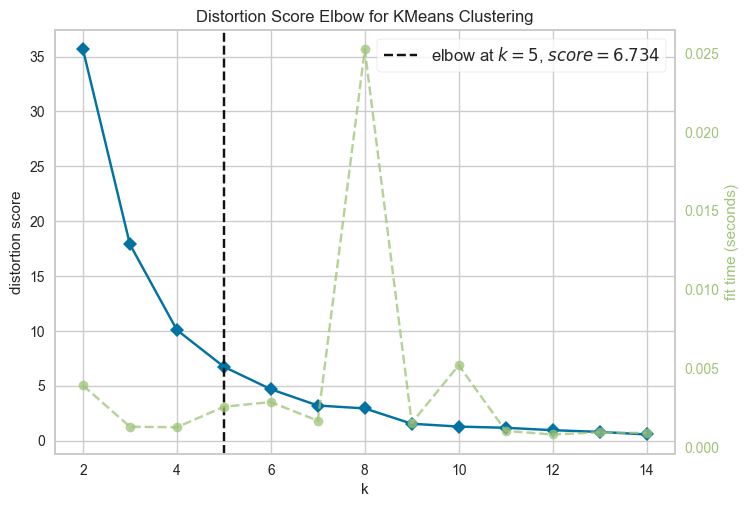

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,15))
visualizer.fit(scaled_data)
visualizer.poof()

In [36]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(scaled_data)

labels = kmeans.predict(scaled_data)
products['CLUSTER'] = labels

In [37]:
products.head(3)

,PRODUCTCODE,PRODUCTLINE,MSRP,CLUSTER
0,S10_1678,Motorcycles,95,0
1,S10_1949,Classic Cars,214,4
2,S10_2016,Motorcycles,118,0


In [38]:
temp = products.groupby('PRODUCTLINE')['MSRP'].mean().reset_index(name="AVG_PRICE")

sc2 = StandardScaler()
scaled_data = sc2.fit_transform(temp[['AVG_PRICE']])

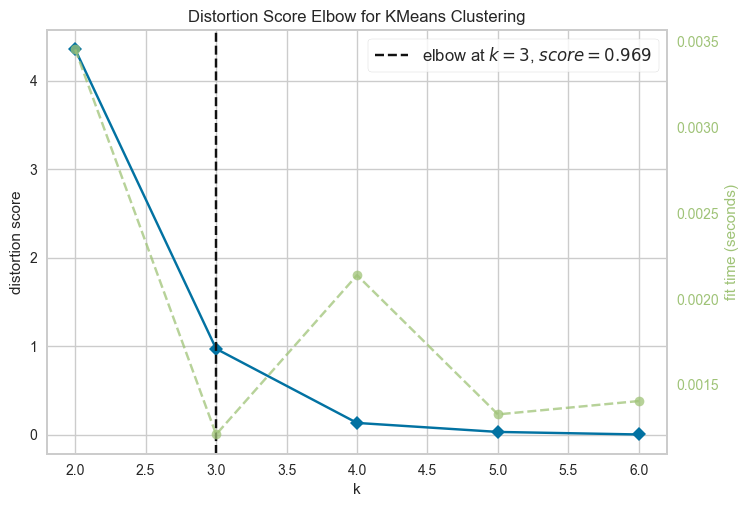

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,7))
visualizer.fit(scaled_data)
visualizer.poof()

In [40]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_data)

labels = kmeans.predict(scaled_data)
temp['CLUSTER_GROUPED'] = labels

In [41]:
temp.head()

,PRODUCTLINE,AVG_PRICE,CLUSTER_GROUPED
0,Classic Cars,117.864865,2
1,Motorcycles,96.692308,0
2,Planes,89.083333,0
3,Ships,86.111111,0
4,Trains,73.333333,1


In [42]:
products = products.merge(temp[['PRODUCTLINE', 'CLUSTER_GROUPED']], on='PRODUCTLINE', how='left')
products.head()

,PRODUCTCODE,PRODUCTLINE,MSRP,CLUSTER,CLUSTER_GROUPED
0,S10_1678,Motorcycles,95,0,0
1,S10_1949,Classic Cars,214,4,2
2,S10_2016,Motorcycles,118,0,0
3,S10_4698,Motorcycles,193,4,0
4,S10_4757,Classic Cars,136,1,2


In [48]:
fig = px.bar(
    products.groupby('PRODUCTLINE').agg({'MSRP': 'mean', 'CLUSTER_GROUPED': 'mean'}).reset_index().sort_values('MSRP', ascending=False),
    y="MSRP",
    x="PRODUCTLINE",
    color="CLUSTER_GROUPED",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    title="Average Price by Product Line",
    xaxis_title="Product Line",
    yaxis_title="Average Price"
)

fig.show()

In [52]:
fig = px.scatter(
    products,
    y="MSRP",
    x="PRODUCTCODE",
    color="CLUSTER",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    title="Average Price by Product Line",
    xaxis_title="Product Line",
    yaxis_title="Average Price"
)

# Dont show product codes
fig.update_xaxes(
    showticklabels=False
)

fig.show()

In [54]:
products.to_csv("../Database/products.csv", sep=",", encoding='Latin-1', index=False)

# Orders

In [55]:
orders.head()

,ORDERNUMBER,ORDERDATE,STATUS,QTR_ID,DEALSIZE,customer_id
0,10107,2003-02-24,Shipped,1,Small,1
1,10121,2003-05-07,Shipped,2,Small,2
2,10134,2003-07-01,Shipped,3,Medium,3
3,10145,2003-08-25,Shipped,3,Medium,4
4,10159,2003-10-10,Shipped,4,Medium,5


# Order Items

In [57]:
order_items.head(3)

,ORDERNUMBER,PRODUCTCODE,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES
0,10107,S10_1678,30,95.70,2,2871.00
1,10121,S10_1678,34,81.35,5,2765.90
2,10134,S10_1678,41,94.74,2,3884.34


There isn't point to try make feature engineering for orders, because every order may be unique, order items too.